## Group 14
Dario Puggioni, ID: 2107760

Alberto Salvador, ID: 2112317

Giancarlo Saran Gattorno, ID: 2106359

Gaia Volpi, ID: 2107759

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


### Selecting and visualizing training and test set

In [2]:
# selecting training set and test set
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


Part of the data:
[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


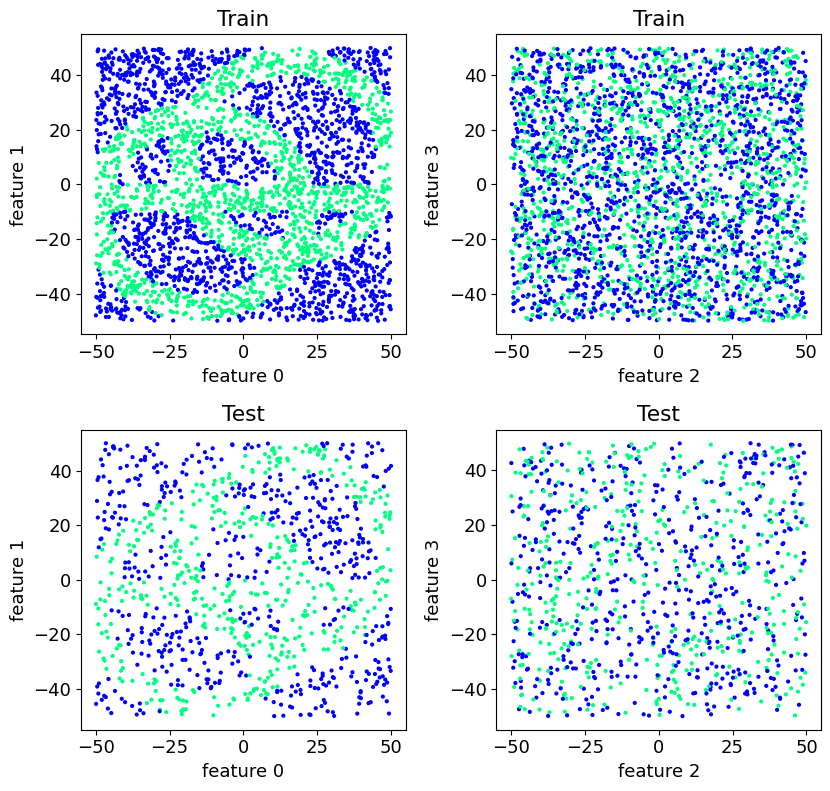

In [79]:
# function to plot the different features of the data
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

print('Part of the data:')
for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

--------------------

In [82]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)

    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)

    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),
            clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()

    if show:
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)

        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)
        plt.show()

### XGBoost best parameters
We classify the training set using XGBoost, evaluating its performance with different parameters.

errors: 5.20%   Accuracy=0.948


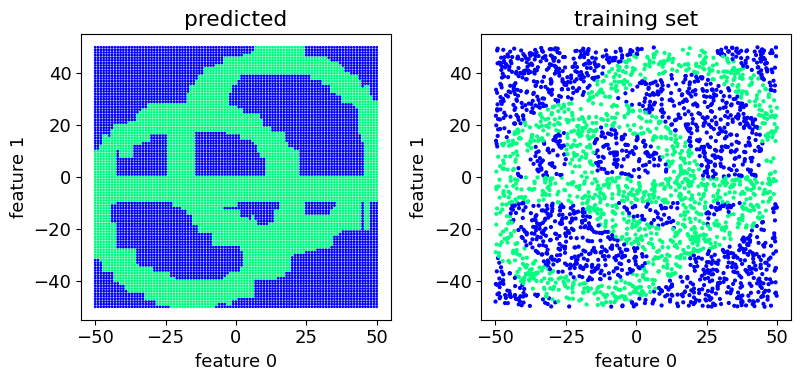

In [12]:
#default parameters

model = XGBClassifier(seed=1,
                      objective='binary:logistic')
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001,
       # n_estimators=30 - number of trees
classify(model)

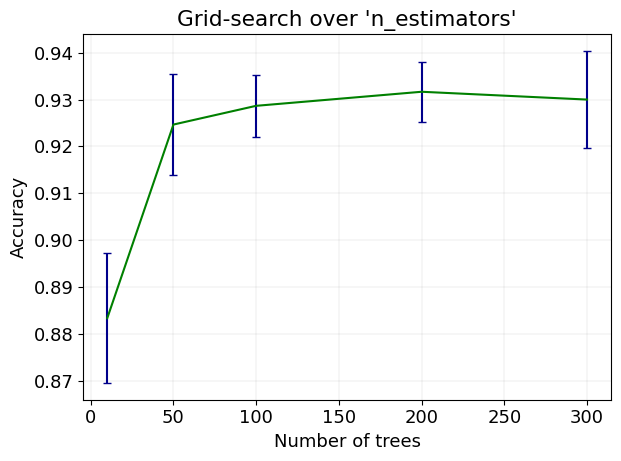

In [ ]:
# we perform a gridsearch of the best number of trees for XGboost

param =dict(n_estimators = [10, 50, 100, 200, 300])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

ecolor, capsize='darkblue', 3
plt.errorbar(param['n_estimators'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)

plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'n_estimators'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

For what concerns the number of trees (*n_estimators*), we see that after a certain limit adding more trees does not improve the performance of the model. The XGBoost algorithm indeed leads to a greater accuracy each time a new tree is added correcting the residuals errors in the predictions from the sequence of previous trees, this eventually leads to a point where no further significant improvements can be obtained. It is important to note that an increase in the number of trees implies a bigger computational burden, this is not justified if the improvement of the accuracy of the model is not significant.

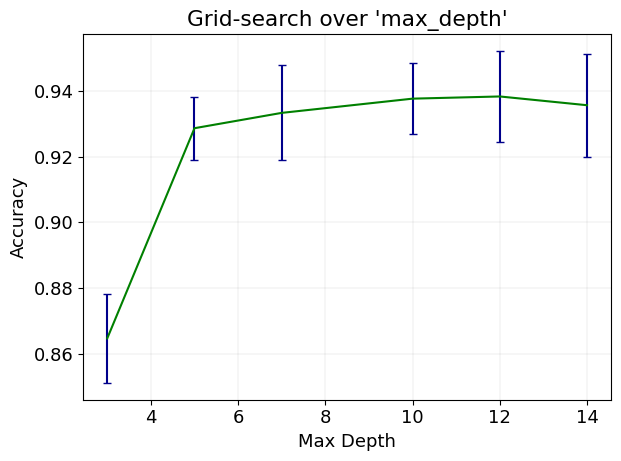

In [ ]:
# we perform a gridsearch of the best tree depth for XGboost
param = dict(max_depth = [3, 5, 7, 10,12,14])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['max_depth'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'max_depth'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

By varying the size of the decision trees (*max_depth*), also called depth of the model, we see that the smallest value leads to a bad performance as the model is capable of capturing less details. Increasing the depth could on the other hand lead to overfitting, with deeper trees capturing too many details and losing the ability to generalize to new unseen data. There is a relationship between the number of trees in the model and the depth of each tree: a greater depth requires fewer trees while shallow ones require many more trees.

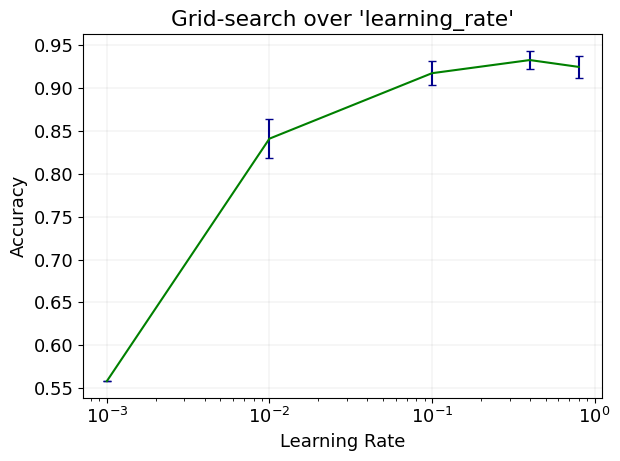

In [ ]:
# we perform a gridsearch of the best learning rate for XGboost
param = dict(learning_rate = [0.8,0.4, 0.1, 0.01, 0.001])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['learning_rate'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'learning_rate'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

The learning rate $\eta$ (*learning_rate*) in XGBoost represents a shrinkage factor for the corrections by new trees when added to the model. The default value is equal to 1.0, smaller values slow down the adaptation of the model to the training data. This implies that more trees need to be added. The smallest value studied ($\eta$ = 0.001) leads to very poor performances with respect to the others.

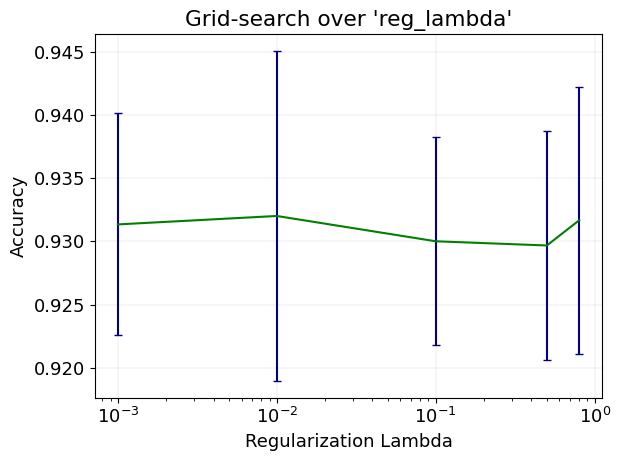

In [ ]:
# we perform a gridsearch of the best regularization lambda for XGboost
param = dict(reg_lambda = [0.8, 0.5, 0.1, 0.01, 0.001])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['reg_lambda'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)
plt.xlabel('Regularization Lambda')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'reg_lambda'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

The lambda value $\lambda$ (*regularization_lambda*) refers to the L2 regularization term on weights, increasing this value will make the model more conservative and reduce overfitting. On the other hand a very high value of $\lambda$ may lead to an underfitting or a highly biased model. From the results obtained it seems that for our problem the value of this parameter, or even the absence of regularization ($\lambda$=0), does not affect much the overall performance of the model.


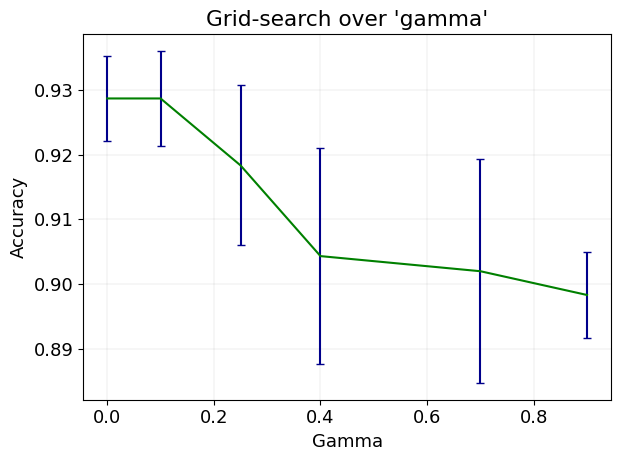

In [ ]:
# we perform a gridsearch of the best gamma for XGboost
param = dict(gamma = [0, 0.1, 0.25, 0.4, 0.7, 0.9])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['gamma'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'gamma'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

The gamma parameter $\gamma$ (*gamma*) is a pseudo-regularization hyperparameter, representing the "complexity cost by introducing additional leaf". By default it is set to 0, but it is useful if we want shallow trees. With our dataset and default values for XGBoost it seems that an increase of this parameter leads to worse performances.

We proceed by performing a GridSearch of the best combination of these hyperparameters. As mentioned above some of them are stricly correlated and the performance of the model needs to be evaluated taking this into account:

In [13]:
# we perform a gridsearch of the best hyperparameters for XGboost
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.4, 0.1, 0.01, 0.001],
    'reg_lambda': [0.5, 0.1, 0.01, 0.0],
    'gamma': [0, 0.1, 0.4, 0.9]
    }

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_result = grid_search.fit(x_train, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
Best set of hyperparameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 0.01}
Best score:  0.9386666666666666


In [14]:
import pandas as pd
results = pd.DataFrame(grid_result.cv_results_)[['param_reg_lambda', 'param_gamma', 'param_n_estimators',
                            'param_learning_rate', 'param_max_depth', 'mean_test_score', 'std_test_score']]

best_results = results.sort_values(by='mean_test_score', ascending=False).iloc[:10]
best_results

,param_reg_lambda,param_gamma,param_n_estimators,param_learning_rate,param_max_depth,mean_test_score,std_test_score
158,0.01,0,300,0.1,10,0.938667,0.016104
72,0.5,0,200,0.4,10,0.937667,0.011086
155,0.0,0,200,0.1,10,0.937000,0.012927
159,0.0,0,300,0.1,10,0.937000,0.010403
68,0.5,0,100,0.4,10,0.936667,0.010698
150,0.01,0,100,0.1,10,0.936667,0.016700
154,0.01,0,200,0.1,10,0.936667,0.016364
64,0.5,0,50,0.4,10,0.936667,0.008882
468,0.5,0.1,100,0.1,10,0.936333,0.011075
156,0.5,0,300,0.1,10,0.936333,0.012311


The above DataFrame shows the best 10 models obtained with our procedure. Taking into account the computational burden of adding more trees to the model, we choose as best model the one characterized by *n_estimators*=50, $\lambda$=0.5, $\gamma$=0, $\eta$=0.4 and *max_depth*=10. Given the stochastic nature of the algorithm the validation accuracy may vary, and with it the choice of the best parameters. We decide to proceed with the ones mentioned above as they seem to be a valid choice.

errors: 5.00%   Accuracy=0.950


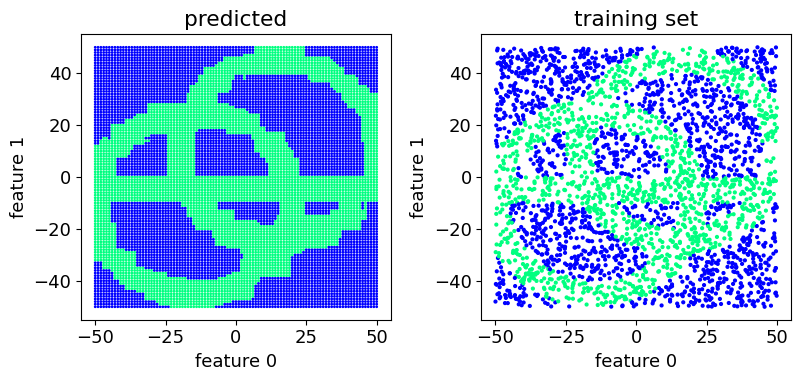

In [16]:
best_model = XGBClassifier(seed=1, objective='binary:logistic', n_estimators=50,
                            reg_lambda=0.5, learning_rate=0.4, max_depth=10)
classify(best_model)

-----------------------
## Dimensionality reduction

XGboost automatically provides a score for each feature of the dataset to indicate its importance in the construction of the model. This score is related to the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for.

We look at the feature importance, considering then reduced data samples with $L’<L$ features.

[0.512004   0.3792628  0.06070577 0.04802735]


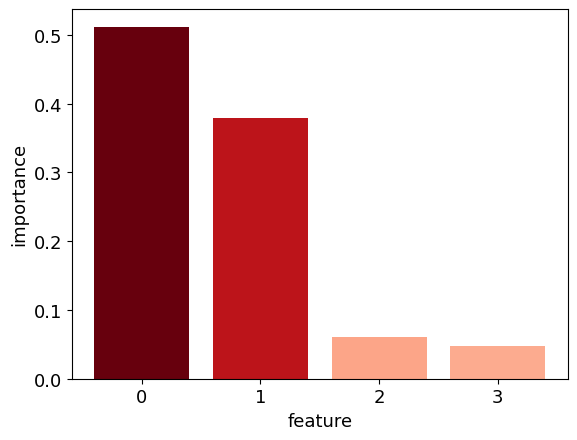

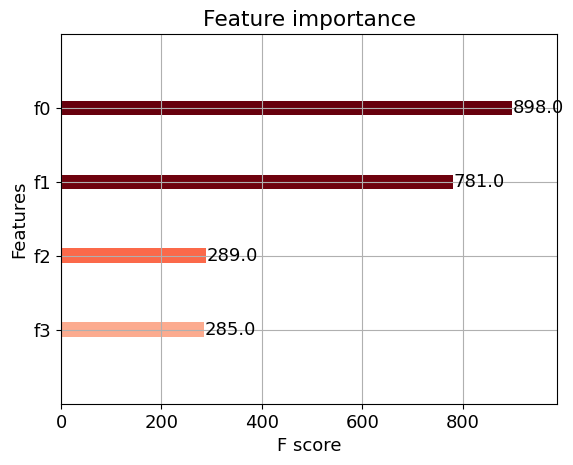

In [17]:
# feature importance
print(best_model.feature_importances_)

# 1: plot model.feature_importances_
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_,
        color=my_cmap(rescale(best_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(best_model.importance_type)
plt.show()

# 2: plot using plot_importance built-in
rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(best_model,color=my_cmap(rescale_r(best_model.feature_importances_)))
plt.show()



    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [898. 781. 289. 285.]
1 gain [3.97397161 2.9436872  0.47117403 0.37276921]
2 total_gain [3568.62646484 2299.01977539  136.16929626  106.23922729]
3 cover [20.4138298  29.54917526 20.60441589 17.65691566]
4 total_cover [18331.61914062 23077.90625     5954.67626953  5032.22070312]


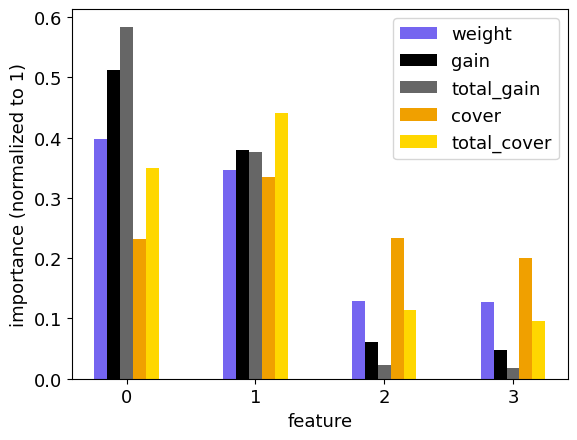

In [18]:
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = best_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

### Method one:

From the plots above it is clear that the most relevant features are 0 and 1: let's try to remove feature 2 and 3 from the dataset and check whether there are some improvements in the accuracy.

In [29]:
dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
x = np.delete(x, 2, axis=1) #remove the 3rd feature
x = np.delete(x, 2, axis=1) #remove the 4th feature

y = np.loadtxt(fnamey)
y = y.astype(int)

N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

errors: 4.50%   Accuracy=0.955


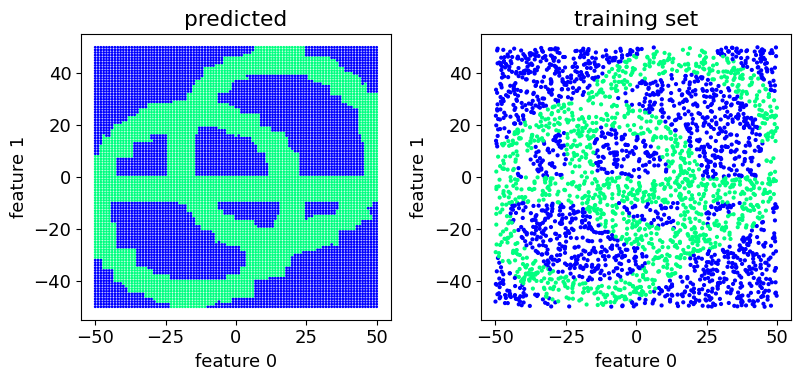

In [30]:
# XGBoost using default parameters
model = XGBClassifier(seed=1,objective='binary:logistic')
classify(model)

It seems that reducing the number of features improves the model's overall performance. Additionally, we have decided to conduct a grid search over the model's hyperparameters to see if better results can be achieved.

In [34]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.4, 0.1, 0.01, 0.001],
    'reg_lambda': [0.5, 0.1, 0.01, 0.0],
    'gamma': [0, 0.2]
    }

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_result = grid_search.fit(x_train, y_train)
print("Best set of hyperparameters: ", grid_search.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best set of hyperparameters:  {'gamma': 0, 'learning_rate': 0.4, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.5}


In [35]:
results = pd.DataFrame(grid_result.cv_results_)[['param_reg_lambda', 'param_gamma', 'param_n_estimators',
                            'param_learning_rate', 'param_max_depth', 'mean_test_score', 'std_test_score']]

best_results = results.sort_values(by='mean_test_score', ascending=False).iloc[:10]
best_results

,param_reg_lambda,param_gamma,param_n_estimators,param_learning_rate,param_max_depth,mean_test_score,std_test_score
40,0.5,0,100,0.4,7,0.948333,0.011402
47,0.0,0,200,0.4,7,0.947667,0.007498
43,0.0,0,100,0.4,7,0.947333,0.007498
44,0.5,0,200,0.4,7,0.947000,0.010403
36,0.5,0,50,0.4,7,0.946667,0.012247
45,0.1,0,200,0.4,7,0.946333,0.008327
93,0.1,0,200,0.1,7,0.946000,0.009580
39,0.0,0,50,0.4,7,0.946000,0.007040
38,0.01,0,50,0.4,7,0.946000,0.009104
90,0.01,0,100,0.1,7,0.946000,0.010414


errors: 4.10%   Accuracy=0.959


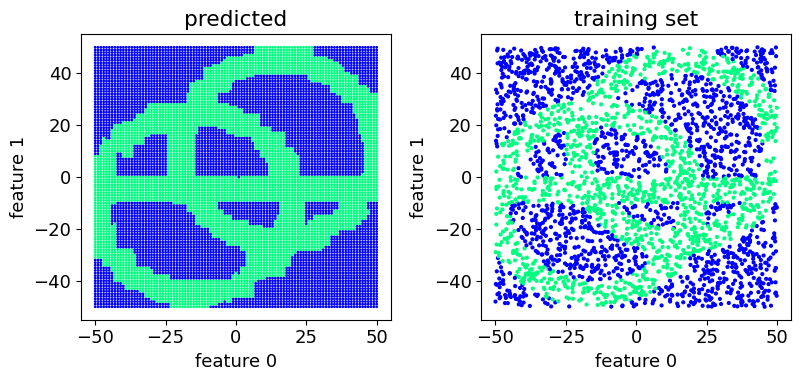

In [36]:
best_model = XGBClassifier(seed=1, objective='binary:logistic', n_estimators=100,
                            reg_lambda=0.5, learning_rate=0.4, max_depth=7, gamma=0)
classify(best_model)

We obtain as best hyperparameters *n_estimators*=100, $\lambda$=0.5, $\gamma$=0, $\eta$=0.4 and *max_depth*=7, which are very similar to the results obtained for the full dataset. In addition one can see that the accuracy is improved. We conclude that the other two features contribute little to the classification task, almost as if they introduced noise into the process.

#### Method two - SelectFromModel:

Another approach to dimensionality reduction involves using a built-in class of scikit-learn called SelectFromModel. 
This class takes the XGBoost model trained with the full dataset to select a subset of features based on their feature importance scores. In particular, it considers only the features to which correspond a score higher than an arbitrary treshold. Here, we consider as tresholds the results obtained from model.feature_importances_. We then proceed to train XGBoost on the reduced dataset using default hyperparameters.

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

#best model for the full dataset (see above)
best_model = XGBClassifier(seed=1, objective='binary:logistic', n_estimators=50,
                            reg_lambda=0.5, learning_rate=0.4, max_depth=10)
best_model.fit(x_train,y_train)
y_hat = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_hat)
print("Best model full accuracy: %.2f%%" % (accuracy*100.0), '\n')

#SelectFromModel on multiple thresholds
thresholds = np.sort(np.array(best_model.feature_importances_))
for thresh in thresholds:
    # SelectFromModel: select features using threshold
    selection = SelectFromModel(best_model, threshold=thresh, prefit=True) #prefit=True - the model has already been trained
    select_X_train = selection.transform(x_train) #subsampling the fulldataset w.r.t the most relevant features
    
    # train model
    selection_model = XGBClassifier(seed=1, objective='binary:logistic')
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(x_test)
    y_hat = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_hat)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Best model full accuracy: 95.00% 

Thresh=0.048, n=4, Accuracy: 94.80%
Thresh=0.061, n=3, Accuracy: 94.10%
Thresh=0.379, n=2, Accuracy: 95.50%
Thresh=0.512, n=1, Accuracy: 57.20%


This outcome further improves the confidence in the hypotesis presented in the first part of this section: superior results are obtained by excluding feature 2 and 3, training the XGBoost on the reduced dataset containing only feature 0 and 1.

------------------------
### XGBoost vs Feed Forward Neural Networks

In [24]:
#using only the relevant features
print(len(x[0]))
#!pip install keras_tuner
from tqdm.notebook import tqdm, trange #loadingbar
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import GridSearch
from keras_tuner import RandomSearch
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

def build_NN(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value=2, max_value=20, step=4) #layer size
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) #learning rate
  hp_regularization = hp.Choice('l2', values=[0.0, 1e-2, 0.1])
  model.add(Dense(units=hp_units, input_shape=(2,), activation='relu', kernel_regularizer=keras.regularizers.l2(l2=hp_regularization)))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])
  return model

2


In [25]:
N = len(x)
split_ratio = np.linspace(0.05, 0.8, 8)

xgb_param_grid = {
    'n_estimators': [20, 100, 250],
    #'max_depth': [3, 5, 7, 10], #remove one of max_depth and gamma, because they're probably redundant, we could check the correlation for the
    #assignment
    'learning_rate': [0.2, 0.05, 0.001],
    'reg_lambda': [0.3, 0.05, 0.0],
    'gamma': [0, 0.2, 0.6]
    }

xgb_results = []
xgb_acc = []
nn_acc = []
xgb_model = XGBClassifier(seed=1,objective='binary:logistic')
tuner = GridSearch(
    build_NN,
    objective='val_accuracy',  # You can also use 'val_loss' or other metrics
    max_trials=10,  # Adjust the number of trials as needed
    overwrite = True
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

for ratio in tqdm(split_ratio, desc='Iterating over ratios'):
    N_train = int(ratio*N)
    #do a shuffle each time
    perm = npr.permutation(len(x))
    xp, yp = x[perm], y[perm]
    x_train, y_train = xp[:N_train],yp[:N_train]
    x_test, y_test = xp[N_train:],yp[N_train:]
    xgb_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', verbose=0)
    xgb_results.append(xgb_search.fit(x_train, y_train))
    y_tf = tf.keras.utils.to_categorical(y_train, num_classes = 2)
    tuner.search(x_train, y_tf, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=0)
    best_model = tuner.get_best_models(num_models=1)[0]
    score, acc = best_model.evaluate(x_test, tf.keras.utils.to_categorical(y_test, num_classes = 2), verbose=0)
    nn_acc.append(acc)
    best_model = xgb_search.best_estimator_
    acc = accuracy_score(y_test, best_model.predict(x_test))
    xgb_acc.append(acc)

Iterating over ratios:   0%|          | 0/8 [00:00<?, ?it/s]

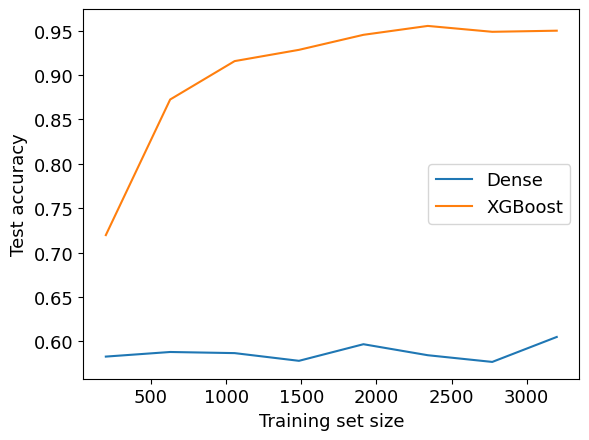

In [28]:
N_trains = [int(ratio*N) for ratio in split_ratio]
fig, ax = plt.subplots()
ax.plot(N_trains, nn_acc, label='Dense')
ax.plot(N_trains, xgb_acc, label='XGBoost')
ax.set_xlabel('Training set size')
ax.set_ylabel('Test accuracy')
ax.legend()
plt.show()

The plot clearly shows how the XGBoost model consistently outperforms the Neural Network model we implemented in the classification task. As the size of the training set increases, the validation accuracy of XGBoost also increases, indicating its effectiveness, especially with large datasets and high-dimensional data.

Looking on the other hand the variation in accuracy of the neural network with respect to the training set size, no notable changes are observed. It seems that the specific architecture we implemented may not be well-suited for this task. We will explore alternative architectures to determine if better results can be attained.

----------------------------------
### Random Forest

Here we try performing a Random Forest algorithm in order to comparing the results with respect to the XGBoost.

In [75]:
from sklearn.ensemble import RandomForestClassifier
param_grid_rf = {'n_estimators': [10,30,60, 100, 200],
                 'max_depth': [3, 5, 7, 10,15,20]}
rand_for = RandomForestClassifier(criterion='gini')
grid_search_rand_for = GridSearchCV(estimator=rand_for, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_result_rand_for = grid_search_rand_for.fit(x_train, y_train)

#print("Best set of hyperparameters: ", grid_search.best_params_)
#print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [77]:
import pandas as pd
rand_for_res_gs=pd.DataFrame(grid_result_rand_for.cv_results_)
rand_for_res_gs['mean_fit_time'] = grid_result_rand_for.cv_results_['mean_fit_time']
print(rand_for_res_gs.columns)
rand_for_res_red=rand_for_res_gs[['rank_test_score','mean_fit_time','std_fit_time','params','mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False)
rand_for_res_red

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


,rank_test_score,mean_fit_time,std_fit_time,params,mean_test_score,std_test_score
29,1,1.795348,0.111488,"{'max_depth': 20, 'n_estimators': 200}",0.922000,0.009452
23,2,0.922342,0.024170,"{'max_depth': 15, 'n_estimators': 100}",0.921333,0.003859
24,3,1.950448,0.041151,"{'max_depth': 15, 'n_estimators': 200}",0.918667,0.012884
28,4,1.059523,0.034184,"{'max_depth': 20, 'n_estimators': 100}",0.917667,0.011624
22,5,0.562455,0.035392,"{'max_depth': 15, 'n_estimators': 60}",0.916667,0.008433
27,6,0.592022,0.022550,"{'max_depth': 20, 'n_estimators': 60}",0.910667,0.009922
26,7,0.309645,0.018829,"{'max_depth': 20, 'n_estimators': 30}",0.910000,0.011450
21,8,0.294524,0.022156,"{'max_depth': 15, 'n_estimators': 30}",0.902667,0.013848
18,9,0.831628,0.007501,"{'max_depth': 10, 'n_estimators': 100}",0.894333,0.015406
17,10,0.519668,0.017705,"{'max_depth': 10, 'n_estimators': 60}",0.892667,0.011671


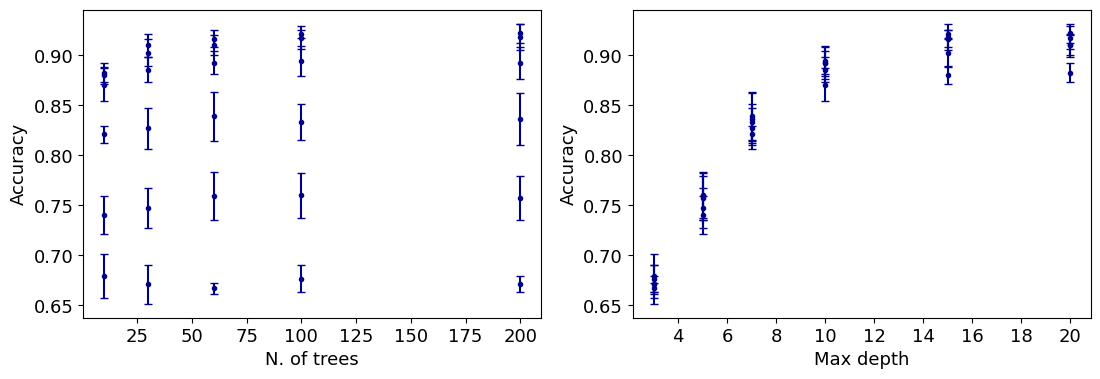

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# Plot per il numero di alberi
ax[0].errorbar(rand_for_res_gs['param_n_estimators'], rand_for_res_gs.mean_test_score, yerr=rand_for_res_gs.std_test_score, fmt='.',color='darkblue',ecolor='darkblue',capsize=3)
ax[0].set_ylabel('Accuracy')  # Imposta l'etichetta sull'asse y
ax[0].set_xlabel('N. of trees')  # Imposta l'etichetta sull'asse x
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Visualizza solo numeri interi sull'asse x

# Plot per la massima profondità
ax[1].errorbar(rand_for_res_gs['param_max_depth'], rand_for_res_gs.mean_test_score, yerr=rand_for_res_gs.std_test_score, fmt='.',color='darkblue',ecolor='darkblue',capsize=3)
ax[1].set_ylabel('Accuracy')  # Imposta l'etichetta sull'asse y
ax[1].set_xlabel('Max depth')  # Imposta l'etichetta sull'asse x
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Visualizza solo numeri interi sull'asse x

plt.show()

errors: 6.10%   Accuracy=0.939


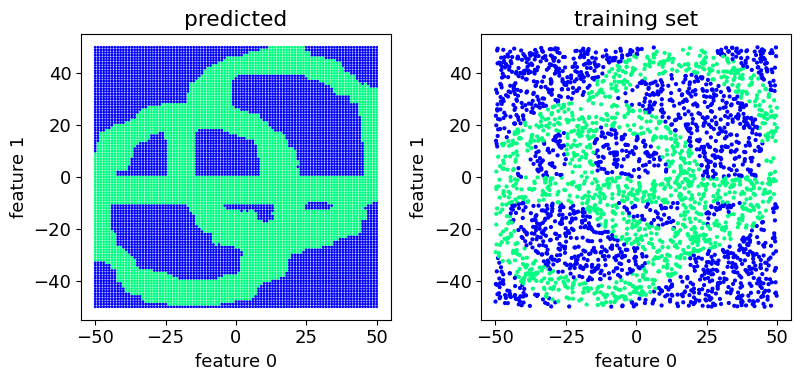

In [84]:
best_rand_for = RandomForestClassifier(n_estimators=200, max_depth=20, criterion='gini', n_jobs=-1)
classify(best_rand_for)